In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

[[ 0.2782208   0.20921635 -0.15783327 -0.11597944  0.50267757]
 [ 0.20921635  0.62540461 -0.07440552 -0.1590074  -0.34949867]
 [-0.15783327 -0.07440552  0.56790749 -0.23986521 -0.04603175]
 [-0.11597944 -0.1590074  -0.23986521  0.53484125  0.11551827]
 [ 0.50267757 -0.34949867 -0.04603175  0.11551827 -0.10637415]]
(5,) (5, 5)


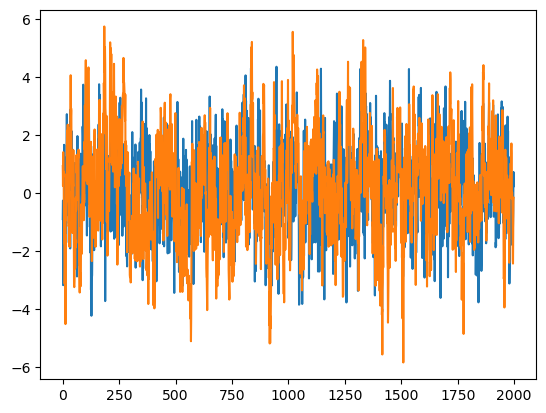

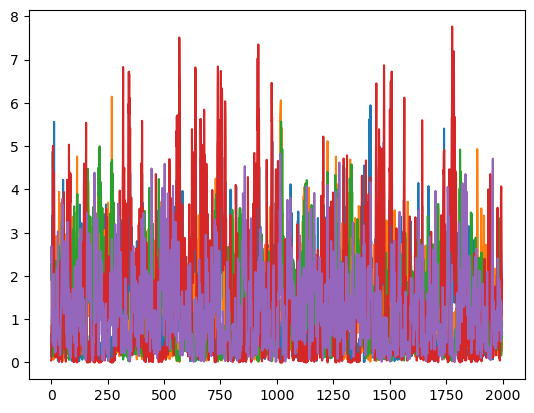

1.1903426981704794


In [6]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 100
z_dim = 5
# x_dim = 5
x_dim = 100

# sqrt m  division in matrix C 

# A = np.array([[0.9, 0.4], [-0.2, 0.8]])
# s = np.array([0.8, 0.99]).reshape(1, -1)
# u, _ = np.linalg.qr(np.random.randn(s.shape[1], s.shape[1]))
# A = u @ np.diag(s.squeeze()) @ u.T
eigs = np.array([-0.6, 0.2, 0.6, 0.8, 0.9])
A = np.diag(eigs)
u, _ = np.linalg.qr(np.random.randn(z_dim, z_dim))
A = u @ A @ u.T
print(A)

# B = np.array([[0.1, 0.0], [0.0, 0.1]])
B = 1 * np.eye(z_dim)
# W = np.eye(x_dim)
W = np.random.randn(x_dim, z_dim) / np.sqrt(z_dim)




# C = np.random.randn(N, x_dim) / np.sqrt(x_dim)
C = np.eye(N)

sigma_x = 0.01

# mu0 = np.array([0., 0.])
# Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
mu0 = np.zeros(z_dim)
Sigma0 = 1 * np.eye(z_dim)
print(mu0.shape, Sigma0.shape)

ntrials = 1
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,z_dim, 1)).squeeze(-1)

T = 2000
v = np.zeros((ntrials,z_dim,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, z_dim,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

_d = 0.5
F = C[None, ...] @ x + _d
# plt.plot(F[0,0,:stop])
# plt.plot(F[0,1,:stop])

# link = np.exp
link = lambda x: 1 * np.log(1 + np.exp(x))
dt = 1
for i in range(5):
    plt.plot(link(F[0,i,:stop])*dt)
plt.show()

# Average firing rate
print(np.mean(link(F)))


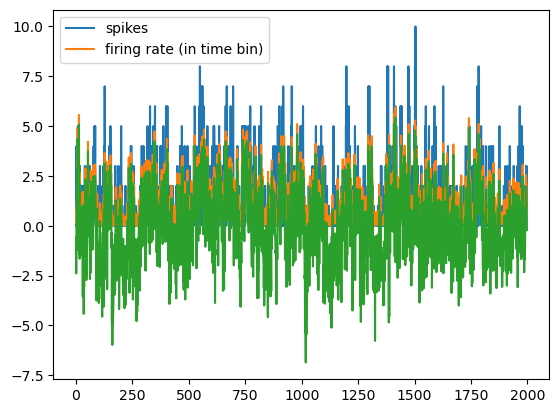

step 0 LL -2.1042684523809525
step 1 LL -2.07595625
step 2 LL -2.050064136904762
step 3 LL -2.025325744047619
step 4 LL -2.0014912202380954
step 5 LL -1.9784333333333333
step 6 LL -1.9561159226190477
step 7 LL -1.9344425595238095
step 8 LL -1.9135044642857142
step 9 LL -1.893139880952381
step 10 LL -1.873463392857143
step 11 LL -1.8543675595238096
step 12 LL -1.8358767857142857
step 13 LL -1.8179846726190476
step 14 LL -1.8006254464285714
step 15 LL -1.7838574404761904
step 16 LL -1.7676738095238096
step 17 LL -1.7519633928571428
step 18 LL -1.7367955357142857
step 19 LL -1.7221505952380953
step 20 LL -1.7079791666666666
step 21 LL -1.6942883928571428
step 22 LL -1.6810822916666666
step 23 LL -1.6683449404761905
step 24 LL -1.6560113095238096
step 25 LL -1.6441241071428572
step 26 LL -1.632621875
step 27 LL -1.6216065476190475
step 28 LL -1.6108876488095238
step 29 LL -1.600626488095238
step 30 LL -1.5906872023809524
step 31 LL -1.5811032738095239
step 32 LL -1.571854017857143
step 33 

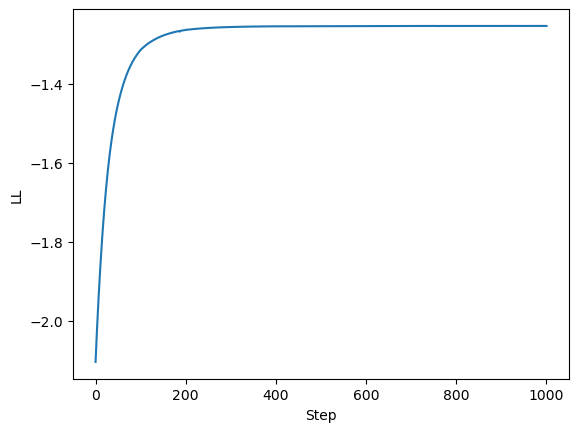

In [8]:
# link_fn = torch.exp
# link = lambda x: np.exp(x)
link_fn = lambda x: 1 * torch.nn.functional.softplus(x)
link = lambda x: 1 * np.log(1 + np.exp(x))
lik = Poisson_noise()
Y = np.random.poisson(link(F)*dt)

train_len = 1000
Y_train = Y[..., :train_len]
v_train = v[..., :train_len]
Y_test = Y[..., train_len:]
v_test = v[..., train_len:]


# sigma = 0.1
# Y = np.random.randn(*F.shape) * sigma + F
# lik = Gaussian_noise(sigma)
# link_fn = lambda x: x

# # Sigmoid link function
# link = lambda x: 1 / (1 + np.exp(-x))
# Y = np.random.negative_binomial(link(F), 0.5)
# lik = Negative_binomial_noise(Tensor(Y))
# link_fn = lambda x:x

plt.plot(Y[0,0,:stop], label='spikes')
# plt.plot(Y[0,1,:stop])
plt.plot(link(F[0,0,:stop])*dt, label='firing rate (in time bin)')
plt.plot(x_noise_free[0,0,:stop])
plt.legend()
plt.show()

# _W = torch.tensor(np.random.randn(1,x_dim, x_dim) / np.sqrt(x_dim)).float().to(device)
# _C = torch.tensor(np.random.randn(1,N, x_dim) / np.sqrt(x_dim)).float().to(device)
model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, d=_d, C=Tensor(C).to(device))
model.C.requires_grad = False

train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 100, 'lrate': 1e-2, 'max_steps': 1001, 'gamma': 0.85, 'StepLR': True}
np.random.seed(0)
torch.manual_seed(0)
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

# # Fixed generative model
# model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, 
#             A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
#             mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
#             sigma_x=(torch.ones(x_dim) * sigma_x).to(device), d=_d)

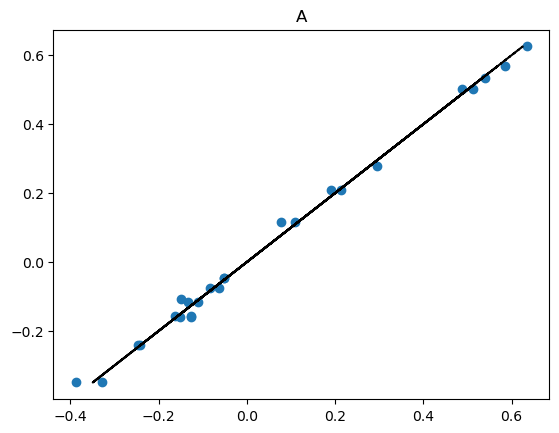

0.48172665 0.5


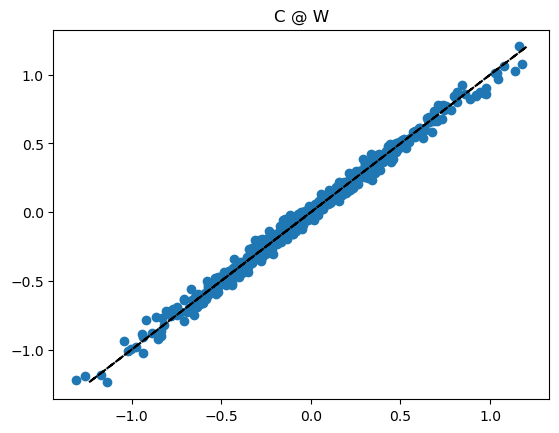

[[[ 0.00318668 -0.19814181  0.17760032 -0.08956414 -0.126644  ]
  [-0.07913847 -0.0553898   0.07542612 -0.09311     0.322186  ]
  [-0.4026393   0.21121629  0.09601452 -0.23658058 -0.02308126]
  [ 0.40032643 -0.4324686  -0.3787052   0.21841028 -0.13488908]
  [ 0.00862668  0.3358522   0.22154877 -0.28074485 -0.01679417]]] [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  1.]]
tensor([0.5391, 0.1344, 0.3402, 0.1100, 0.0721, 0.0283, 0.5563, 0.1561, 0.4204,
        0.1853, 0.3675, 0.1461, 0.1525, 0.3177, 0.3974, 0.1677, 0.3737, 0.1391,
        0.2376, 0.1354, 0.0661, 0.0747, 0.2621, 0.1105, 0.5394, 0.3116, 0.0900,
        0.1692, 0.3276, 0.5135, 0.0794, 0.1214, 0.1023, 0.0374, 0.2348, 0.3271,
        0.3321, 0.1469, 0.1232, 0.1276, 0.0988, 0.4204, 0.1237, 0.1984, 0.4012,
        0.0740, 0.2981, 0.5833, 0.0320, 0.0795, 0.3768, 0.1625, 0.1903, 0.4246,
        0.0441, 0.0896, 0.1305, 0.0568, 0.1347, 0.0556, 0.1341, 0.0908, 0.2604,
  

In [9]:
# for name, prm in model.named_parameters():
#     if name in ['C', 'W']:
#         continue
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# # print(C @ W )
# # print(model.C @ model.W)
# print((C@W - (model.C @ model.W).detach().cpu().numpy()))
# # print(C @ W)
# print(model.Sigma0)

plt.plot(model.A.detach().cpu().numpy().flatten(), A.flatten(), 'o')
# plot y = x line 
plt.plot(A.flatten(), A.flatten(), 'k--')
plt.title('A')
plt.show()

print(model.d.detach().cpu().numpy(), _d)

plt.plot((model.C @ model.W).detach().cpu().numpy().flatten(), (C @ W).flatten(), 'o')
# plot y = x line
plt.plot((C @ W).flatten(), (C @ W).flatten(), 'k--')
plt.title('C @ W')
plt.show()

print(model.Sigma0_half.detach().cpu().numpy(), np.linalg.cholesky(Sigma0))

print(model.sigma_x, sigma_x)

print(model.mu0.detach().cpu().numpy(), mu0)

print(model.B, B)


torch.Size([1, 1, 5, 1000])


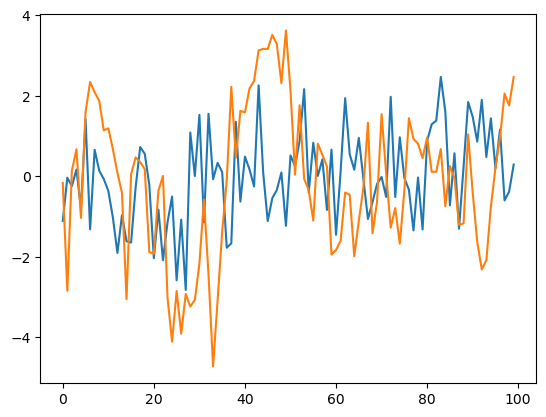

In [10]:
model.freeze_params()
z_samps = model.sample_z(1, trials=1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

In [6]:
# Load saved neural network
state_dict = torch.load('my_sequential_model.pth')

100
step 0 LL -1.707854765625 Entropy -0.1393130859375 Joint LL -1.568541640625
step 1 LL -1.6681096875 Entropy -0.1393130859375 Joint LL -1.5287965625
step 2 LL -1.635638671875 Entropy -0.1393130859375 Joint LL -1.496325546875
step 3 LL -1.603662734375 Entropy -0.1393130859375 Joint LL -1.464349609375
step 4 LL -1.576575859375 Entropy -0.1393130859375 Joint LL -1.437262734375
step 5 LL -1.55868953125 Entropy -0.1393130859375 Joint LL -1.41937640625
step 6 LL -1.55062984375 Entropy -0.1393130859375 Joint LL -1.41131671875
step 7 LL -1.54864796875 Entropy -0.1393130859375 Joint LL -1.40933484375
step 8 LL -1.546230390625 Entropy -0.1393130859375 Joint LL -1.406917265625
step 9 LL -1.54875328125 Entropy -0.1393130859375 Joint LL -1.40944015625
step 10 LL -1.5495359375 Entropy -0.1393130859375 Joint LL -1.4102228125
step 11 LL -1.54846921875 Entropy -0.1393130859375 Joint LL -1.40915609375
step 12 LL -1.54707703125 Entropy -0.1393130859375 Joint LL -1.40776390625
step 13 LL -1.54391 Entro

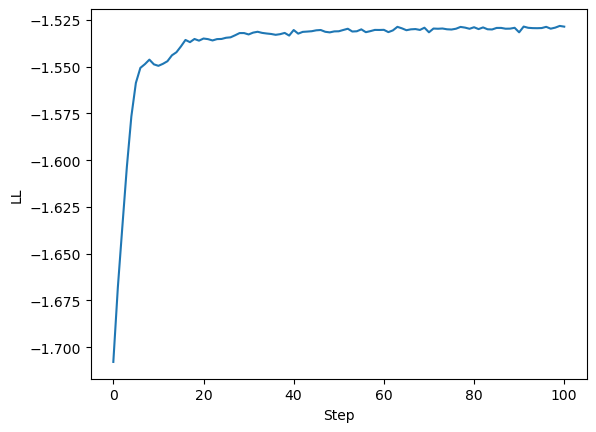

In [11]:

model.freeze_params()
print(model.x_dim)

# class MyRNNModel(Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyRNNModel, self).__init__()
#         self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
#         self.fc = torch.nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out)
#         return out

# neural_net = MyRNNModel(model.N, 100, model.x_dim)

# # # Substituting the true parameters
# # neural_net = torch.nn.Sequential(
# #                 torch.nn.Linear(model.N, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 # torch.nn.Linear(100, 100),
# #                 # torch.nn.ReLU(),
# #                 torch.nn.Linear(100, model.x_dim)
# #             )
# # # neural_net.load_state_dict(state_dict)
# # # rec_model = RecognitionModel(model, neural_net=neural_net)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # needs ntrials, T, N
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = RNNModel(model.N, 100, model.x_dim)
# neural_net.load_state_dict(state_dict)

rec_model = RecognitionModel(model, rnn=False)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 101, 'n_mc_x': 50, 'n_mc_z': 50, 'batch_mc_z': 25}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

torch.Size([1, 100, 1000])


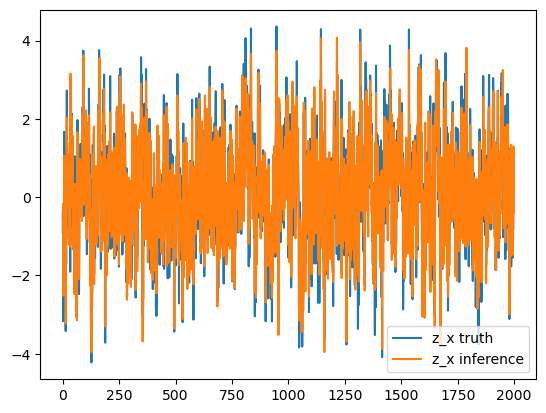

0.8948838516880807 z_0
0.9193835816650667 z_1
0.9208841658926751 z_2
0.9183826669325088 z_3
0.8916918022718722 z_4
(1, 100, 2000)


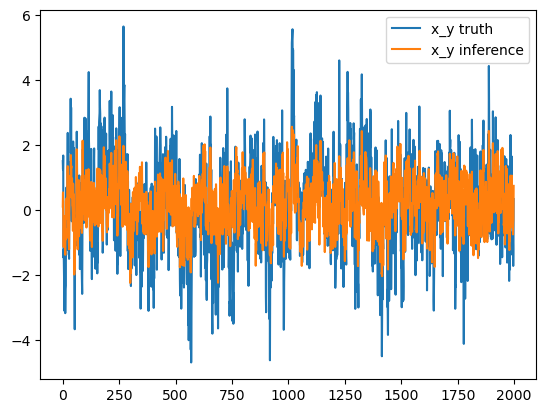

0.47123934537659873 x_0
0.37756060117596 x_1
-0.25008043929456636 x_2
0.7787550972186478 x_3
0.05916761275588922 x_4
-0.6987395965618213 x_5
0.5600623657241586 x_6
0.18773391406054352 x_7
-0.07728625767951014 x_8
0.4272582415121634 x_9
-0.9831165964772133 x_10
-1.0601262536796923 x_11
-0.23589789864205146 x_12
0.5533841809031678 x_13
-0.718955551860565 x_14
0.41190301669609697 x_15
0.034119929614628175 x_16
0.21421194309644487 x_17
-1.225781258644587 x_18
0.4333113698715424 x_19
-0.514263951127671 x_20
-0.594230393712939 x_21
0.417955821643924 x_22
-0.6898091114809861 x_23
0.11270683389211478 x_24
0.42057662557162034 x_25
-0.715979285320735 x_26
0.16254159961722647 x_27
0.587627157467369 x_28
0.3449840999348427 x_29
-6.155329034359012 x_30
-0.17376870804465927 x_31
-1.4471021880903203 x_32
-1.2441989468623005 x_33
0.3606964767089177 x_34
0.6792125810751255 x_35
-1.1049618882071872 x_36
0.016116659171534153 x_37
0.3995282750685807 x_38
-0.5497600157364317 x_39
-9.388432009708195 x_40
-2

In [13]:
print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(Tensor(Y).to(device))
z = z.detach().cpu().numpy()

start = 0
stop = -1
plt.plot(v[0,0,start:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,start:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# for i in range(5):
#     plt.plot(z[0,i,:stop], label = 'z_x inference')
# plt.show()
# for i in range(5):
#     plt.plot(v[0,i,:stop], label = 'z_x truth')   
#     # plt.legend()
# plt.show()

# print R^2 for x and y decoding using sklearn
# print(r2_score(v[0,1,:], z[0,1,:]))
# print(r2_score(v[0,0,:], z[0,0,:]))
for i in range(rec_model.gen_model.b):
    print(r2_score(v[0,i,train_len:], z[0,i,train_len:]), 'z_{}'.format(i))

x_tilde = rec_model.get_x_tilde(Tensor(Y).to(device)).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x_noise_free[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x_noise_free[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()
# print R^2 for x_tilde
for i in range(rec_model.gen_model.x_dim):
    print(r2_score(x_noise_free[0,i,:], x_tilde[0,i,:]), 'x_{}'.format(i))
# print(r2_score(x_noise_free[0,0,:], x_tilde[0,0,:]), 'x_x')
# print(r2_score(x_noise_free[0,1,:], x_tilde[0,1,:]), 'x_y')
# print(r2_score(x_noise_free, x_tilde), 'x_all')

# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# # _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
# print(mus_smooth.shape)
# stop = 100
# plt.plot(v[0,0,:stop], label = 'z_x truth')
# plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
# plt.plot(v[0,1,:stop], label = 'z_y truth')
# plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
# plt.legend()
# plt.show()

# # print R^2 for x and y smoothing using sklearn
# print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
# print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [15]:
_A = Tensor(A).to(device)
_W = Tensor(W).to(device)
_Q = Tensor(B @ B.T).to(device)
_R = Tensor(np.eye(N) * sigma_x**2).to(device)
_Sigma0 = Tensor(Sigma0).to(device)
_mu0 = Tensor(mu0).to(device)
gaussian_Y = Tensor(Y - Y.mean(2)[..., None]).to(device)
_, _, Ks, Cs = general_kalman_covariance(A=_A, W=_W, Q=_Q, R=_R, b=z_dim, x_dim=x_dim, Sigma0=_Sigma0, T=2000, get_sigma_tilde=False, smoothing=True)
_, gaussian_mus_smooth, _ = general_kalman_means(A=_A, W=_W, b=z_dim, mu0=_mu0, x_hat=gaussian_Y[None, ...], Ks=Ks, Cs=Cs, smoothing=True)

torch.Size([2000, 1, 1, 5])
0.7770144806467056
0.7925694178932048
0.8031060473561887
0.7960966406272614
0.7804669549160879


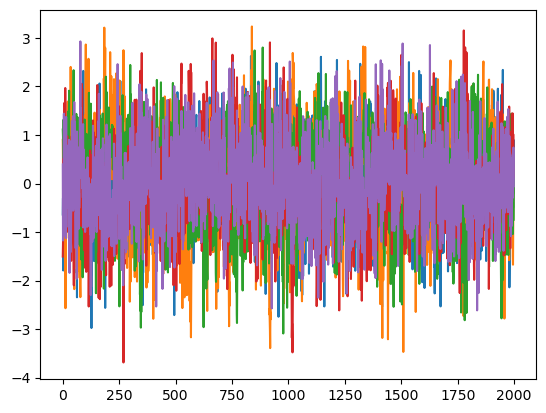

In [18]:
print(gaussian_mus_smooth.shape) # (T, n_mc, ntrials, b)
gaussian_z = gaussian_mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0) # (ntrials, b, T)
for i in range(5):
    plt.plot(gaussian_z[0,i,:stop], label = 'z inf')
    print(r2_score(v[0,i,:], gaussian_z[0,i,:]))

In [ ]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100)
print(matheron_pert.shape)
x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
print(x_hat.shape)
_, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)


# # Find the prior mean
# z_samps = model.sample_z(10000)
# z_samps = z_samps.squeeze().detach().cpu().numpy()
# print(z_samps.shape)

In [ ]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = -1
posterior_avg = _mus_smooth.mean(0)
posterior_std = _mus_smooth.std(0)
# prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))